In [1]:
import unicodedata
import re
import pandas as pd

# =====================================================================

# ファイルを開いて全文、タイトル、著者を読み込む
with open('data/hashire_merosu.txt', mode='r', encoding='UTF-8') as f:
    title = f.readline()
    author = f.readline()
    content = f.read()

# 改行を無くし全文をつなげる
content = ' '.join(content.split())
# 文章を正規化する
content = unicodedata.normalize('NFKC', content)

# 本文以外に該当する部分を切り離す
pattern = re.compile(r'^.+(#地から1字上げ].+#地から1字上げ]).+$')
body =re.match(pattern, content).group(1)

# 本文のみにクリーニングする
body = body.replace('#地から1字上げ] -------------------------------------------------------', '')
body = body.replace(' [#地から1字上げ]', '')

# タイトルと著者を別途取って来る(改行を除外)
title = title.replace('\n', '')

author = author.replace('\n', '')

# =====================================================================

# ファイルを開いて全文を読み込む
with open('data/hashire_merosu.txt', mode='r', encoding='UTF-8') as f:
    content = f.readlines()

# データフレームに全文を1行ずつ入れる
df = pd.DataFrame(content, columns=['text'])
df['text'] = df['text'].str.replace('\n', '')

# 公開日と修正日について
date = df[(df['text'].str.contains('日公開'))|(df['text'].str.contains('日修正'))].copy()

date['text'] = date['text'].str.replace('公開', '')
date['text'] = date['text'].str.replace('修正', '')

date['text'] = date['text'].str.replace('年', '/')
date['text'] = date['text'].str.replace('月', '/')
date['text'] = date['text'].str.replace('日', '')

date['text'] = pd.to_datetime(date['text'])
date.dtypes

# 取得した日時と計算結果
release_date = date.iat[0, 0]
update_date = date.iat[1, 0]
# print(release_date)
# print(update_date)

date = update_date - release_date


# 取得項目を格納したデータフレーム
booklist = pd.DataFrame([[title, author, release_date, update_date, body]],
columns = ['title', 'author', 'release_date', 'update_date', 'body'])

print(booklist)

   title author release_date update_date  \
0  走れメロス    太宰治   2000-12-04  2011-01-17   

                                                body  
0   メロスは激怒した。必ず、かの邪智暴虐《じゃちぼうぎゃく》の王を除かなければならぬと決意した...  


C:\Users\ryoun\AppData\Local\Temp\ipykernel_18856\986321221.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
booklist

,title,author,release_date,update_date,body
0,走れメロス,太宰治,2000-12-04,2011-01-17,メロスは激怒した。必ず、かの邪智暴虐《じゃちぼうぎゃく》の王を除かなければならぬと決意した...


In [5]:
import MeCab
tagger = MeCab.Tagger()
body = booklist.iloc[0, 4]
parsed = tagger.parse(body).split('\n')
parsed[:4]

['メロス\t名詞,一般,*,*,*,*,*',
 'は\t助詞,係助詞,*,*,*,*,は,ハ,ワ',
 '激怒\t名詞,サ変接続,*,*,*,*,激怒,ゲキド,ゲキド',
 'し\t動詞,自立,*,*,サ変・スル,連用形,する,シ,シ']

In [7]:
parsed[-4:]

['た\t助動詞,*,*,*,特殊・タ,基本形,た,タ,タ', '。\t記号,句点,*,*,*,*,。,。,。', 'EOS', '']

In [8]:
parsed = parsed[:-2]
parsed[-4:]

['赤面\t名詞,サ変接続,*,*,*,*,赤面,セキメン,セキメン',
 'し\t動詞,自立,*,*,サ変・スル,連用形,する,シ,シ',
 'た\t助動詞,*,*,*,特殊・タ,基本形,た,タ,タ',
 '。\t記号,句点,*,*,*,*,。,。,。']

In [11]:
import re

In [13]:
*values, = map(lambda s: re.split(r'\t|,', s), parsed)
values[:4]

[['メロス', '名詞', '一般', '*', '*', '*', '*', '*'],
 ['は', '助詞', '係助詞', '*', '*', '*', '*', 'は', 'ハ', 'ワ'],
 ['激怒', '名詞', 'サ変接続', '*', '*', '*', '*', '激怒', 'ゲキド', 'ゲキド'],
 ['し', '動詞', '自立', '*', '*', 'サ変・スル', '連用形', 'する', 'シ', 'シ']]

In [39]:
import pandas as pd 
columns = ['表層形', '品詞', '品詞細分類1', '品詞細分類2', '品詞細分類3', '活用形', '活用形', '原形', '読み', '発音']
mecab_df = pd.DataFrame(data=values, columns=columns)
print(len(mecab_df))
mecab_df.head(4)

6712


,表層形,品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用形,原形,読み,発音
0,メロス,名詞,一般,*,*,*,*,*,None,None
1,は,助詞,係助詞,*,*,*,*,は,ハ,ワ
2,激怒,名詞,サ変接続,*,*,*,*,激怒,ゲキド,ゲキド
3,し,動詞,自立,*,*,サ変・スル,連用形,する,シ,シ


In [40]:
print(mecab_df.groupby(['原形', '品詞']).size().sort_values(ascending=False))

原形    品詞
、     記号    555
。     記号    458
は     助詞    268
て     助詞    237
の     助詞    225
           ... 
け     助詞      1
反駁    名詞      1
取り直す  動詞      1
取り返す  動詞      1
齧る    動詞      1
Length: 1325, dtype: int64


In [41]:
noun = mecab_df.loc[mecab_df['品詞'] == '名詞']
noun

,表層形,品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用形,原形,読み,発音
0,メロス,名詞,一般,*,*,*,*,*,None,None
2,激怒,名詞,サ変接続,*,*,*,*,激怒,ゲキド,ゲキド
9,邪智,名詞,一般,*,*,*,*,邪智,ジャチ,ジャチ
10,暴虐,名詞,一般,*,*,*,*,暴虐,ボウギャク,ボーギャク
13,ゃちぼうぎゃく,名詞,固有名詞,組織,*,*,*,*,None,None
...,...,...,...,...,...,...,...,...,...,...
6691,皆,名詞,代名詞,一般,*,*,*,皆,ミナ,ミナ
6695,の,名詞,非自立,一般,*,*,*,の,ノ,ノ
6700,の,名詞,非自立,一般,*,*,*,の,ノ,ノ
6704,勇者,名詞,一般,*,*,*,*,勇者,ユウシャ,ユーシャ


In [42]:
print(noun.groupby(['原形']).size().sort_values(ascending=False))

原形
*      155
の       78
私       76
人       30
おまえ     20
      ... 
喉        1
品々       1
哀願       1
哀れ       1
黒雲       1
Length: 672, dtype: int64


In [43]:
verb = mecab_df.loc[(mecab_df['品詞'] == '名詞')|(mecab_df['品詞'] == '動詞')]
verb

,表層形,品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用形,原形,読み,発音
0,メロス,名詞,一般,*,*,*,*,*,None,None
2,激怒,名詞,サ変接続,*,*,*,*,激怒,ゲキド,ゲキド
3,し,動詞,自立,*,*,サ変・スル,連用形,する,シ,シ
9,邪智,名詞,一般,*,*,*,*,邪智,ジャチ,ジャチ
10,暴虐,名詞,一般,*,*,*,*,暴虐,ボウギャク,ボーギャク
...,...,...,...,...,...,...,...,...,...,...
6695,の,名詞,非自立,一般,*,*,*,の,ノ,ノ
6700,の,名詞,非自立,一般,*,*,*,の,ノ,ノ
6704,勇者,名詞,一般,*,*,*,*,勇者,ユウシャ,ユーシャ
6708,赤面,名詞,サ変接続,*,*,*,*,赤面,セキメン,セキメン


In [44]:
with open('data/stop_words.txt', mode='r', encoding='UTF-8') as f:
    stop_words = f.read().split()
stop_words

['する', 'いる', 'なる', 'れる', 'よう']

In [45]:
print(len(noun))
noun = noun.loc[~noun['原形'].isin(stop_words)]
print(len(noun))
display(noun.head())

print(len(verb))
verb = verb.loc[~verb['原形'].isin(stop_words)]
print(len(verb))
display(verb.head())

1686
1673


,表層形,品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用形,原形,読み,発音
0,メロス,名詞,一般,*,*,*,*,*,None,None
2,激怒,名詞,サ変接続,*,*,*,*,激怒,ゲキド,ゲキド
9,邪智,名詞,一般,*,*,*,*,邪智,ジャチ,ジャチ
10,暴虐,名詞,一般,*,*,*,*,暴虐,ボウギャク,ボーギャク
13,ゃちぼうぎゃく,名詞,固有名詞,組織,*,*,*,*,None,None


2666
2448


,表層形,品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用形,原形,読み,発音
0,メロス,名詞,一般,*,*,*,*,*,None,None
2,激怒,名詞,サ変接続,*,*,*,*,激怒,ゲキド,ゲキド
9,邪智,名詞,一般,*,*,*,*,邪智,ジャチ,ジャチ
10,暴虐,名詞,一般,*,*,*,*,暴虐,ボウギャク,ボーギャク
13,ゃちぼうぎゃく,名詞,固有名詞,組織,*,*,*,*,None,None


In [46]:
count = noun.groupby('原形').size().sort_values(ascending=False)
count.name = 'count'
count = count.reset_index().head(11)
count

,原形,count
0,*,155
1,の,78
2,私,76
3,人,30
4,おまえ,20
5,王,19
6,友,18
7,事,15
8,君,13
9,三,12


In [47]:
pip install -q japanize-matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: xlabel='count', ylabel='原形'>

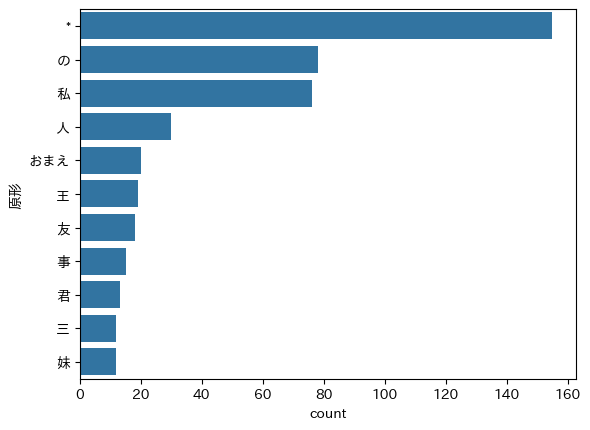

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
plt.figure(figure=(10, 5))
sns.barplot(x=count['count'], y=count['原形'])


In [50]:
!apt-get -yq install fonts-ipafont-gothic

'apt-get' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B


In [51]:
ls /user/share/fonts/opentype/ipafont-gothic

�����ȃX�C�b�`�ł� - "user"


In [52]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


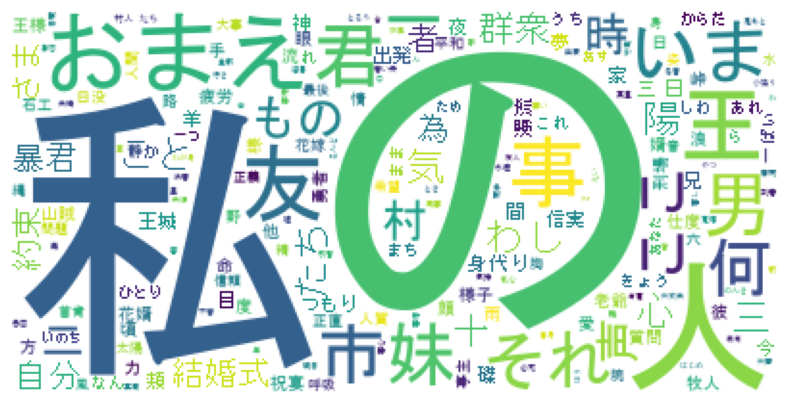

In [53]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import japanize_matplotlib
font_path = '‪C:\Windows\Fonts\msgothic.ttc'
cloud = WordCloud(background_color='white', font_path=font_path).generate(' '.join(noun['原形'].values))
plt.figure(figsize=(10, 5))
plt.imshow(cloud)
plt.axis("off")
plt.savefig('data/wc_noun_base_2.png')
plt.show()

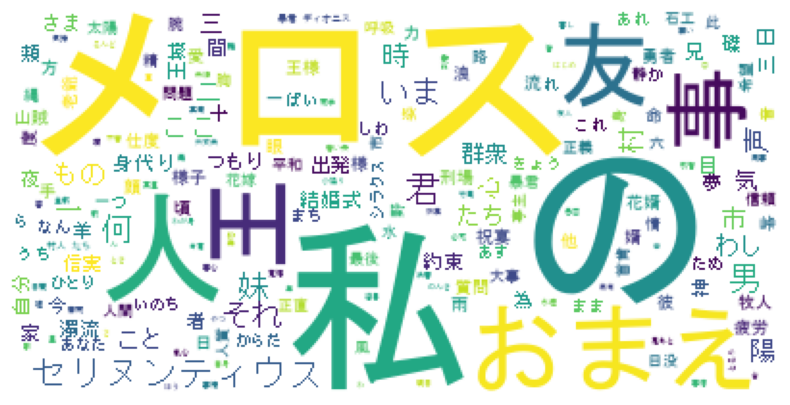

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import japanize_matplotlib
font_path = '‪C:\Windows\Fonts\msgothic.ttc'
cloud = WordCloud(background_color='white', font_path=font_path).generate(' '.join(noun['表層形'].values))
plt.figure(figsize=(10, 5))
plt.imshow(cloud)
plt.axis("off")
plt.savefig('data/wc_noun_surface.png')
plt.show()

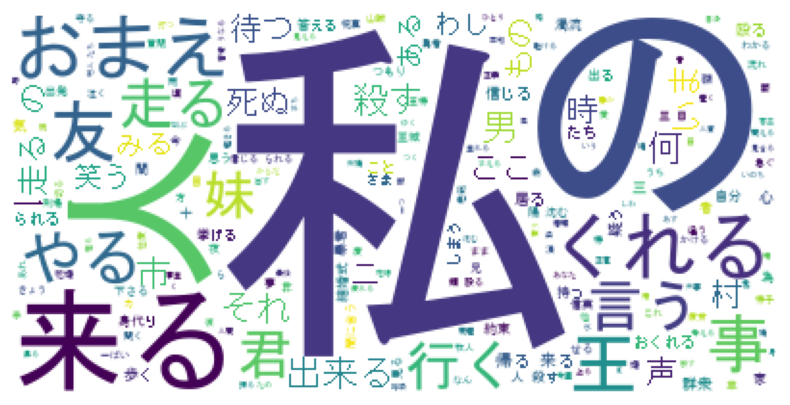

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import japanize_matplotlib
font_path = '‪C:\Windows\Fonts\msgothic.ttc'
cloud = WordCloud(background_color='white', font_path=font_path).generate(' '.join(verb['原形'].values))
plt.figure(figsize=(10, 5))
plt.imshow(cloud)
plt.axis("off")
plt.savefig('data/wc_verb_base.png')
plt.show()

In [56]:
target = mecab_df['表層形'].to_list()
len(target)

6712

In [58]:
pip install nltk


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
     ---------------------------------------- 0.0/302.2 kB ? eta -:--:--
     -------------------------------------- 302.2/302.2 kB 9.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/269.5 kB ? eta -:--:--
     ------------------------------------- 269.5/269.5 kB 17.3 MB/s eta 0:00:00
  Using cached click-8.1.7-py3-none-any.whl (97 kB)


In [59]:
from nltk import ngrams
bigram = ngrams(target, 2)

In [60]:
import collections
counter = collections.Counter(bigram)
print(counter)

Counter({('た', '。'): 142, ('は', '、'): 129, ('だ', '。'): 72, ('。', '」'): 55, ('メロス', 'は'): 47, ('の', 'だ'): 45, ('て', '、'): 39, ('私', 'は'): 36, ('。', '私'): 34, ('。', 'メロス'): 33, ('て', 'いる'): 33, ('。', '「'): 31, ('し', 'た'): 25, ('し', 'て'): 25, ('」', '「'): 24, ('に', 'は'): 22, ('た', 'の'): 22, ('ぬ', '。'): 21, ('が', '、'): 21, ('も', '、'): 20, ('を', '、'): 18, ('に', '、'): 18, ('、', 'メロス'): 18, ('て', 'くれ'): 18, ('、', '私'): 17, ('て', '来'): 16, ('私', 'を'): 16, ('無い', '。'): 15, ('で', '、'): 15, ('ああ', '、'): 15, ('ある', '。'): 14, ('来', 'た'): 14, ('い', 'た'): 14, ('なら', 'ぬ'): 13, ('で', 'ある'): 13, ('て', 'い'): 13, ('れ', 'た'): 13, ('ない', '。'): 13, ('》', 'の'): 12, ('の', 'は'): 12, ('、', 'と'): 12, ('ます', '。'): 12, ('う', '。'): 12, ('あっ', 'た'): 11, ('に', 'なっ'): 11, ('いる', '。'): 11, ('で', 'は'): 11, ('か', '。'): 11, ('私', 'の'): 11, ('なっ', 'て'): 10, ('。', 'おまえ'): 10, ('で', 'あっ'): 9, ('の', '、'): 9, ('人', 'を'): 9, ('」', 'メロス'): 9, ('メロス', 'の'): 9, ('よう', 'に'): 9, ('帰っ', 'て'): 9, ('。', 'ああ'): 9, ('。', 'その'): 8, ('から', '

In [63]:
# インポート類
import numpy as np
import pandas as pd
import MeCab

# 読み込む対象のリスト
documents = [
    '子どもが走る',
    '車が走る',
    '子どもの脇を車が走る'
]

# 単語のリストを作る
words_list = []

# MeCabを初期化する
tagger = MeCab.Tagger()

# 生成する辞書
word2int = {}
i = 0

# 形態素解析して辞書に入れていく
for sentence in documents:
    sentence_parced = tagger.parse(sentence)
    words_in_sentence = []
    for line in sentence_parced.splitlines()[:-1]:
        words_in_sentence.append(line.split('\t')[0])
        if line.split('\t')[0] not in word2int:
            word2int[line.split('\t')[0]] = i
            i += 1
    words_list.append(words_in_sentence)


# BoWを作る
bow = np.zeros((len(words_list), len(word2int)), dtype=np.int64)
for i, words in enumerate(words_list):
    for word in words:
        bow[i, word2int[word]] += 1

# pandas形式にする
df_bow = pd.DataFrame(bow, columns=list(word2int))

# 表示
display(df_bow)


,子ども,が,走る,車,の,脇,を
0,1,1,1,0,0,0,0
1,0,1,1,1,0,0,0
2,1,1,1,1,1,1,1


In [ ]:
# インポート類
import numpy as np
import pandas as pd
import MeCab
import unicodedata
import re

text_paths = ["data/hashire_merosu.txt","data/rashomon.txt","data/gakumonno_susume.txt"]
documents = []

for i in text_paths:
    # ファイルを開いて全文、タイトル、著者を読み込む
    with open(i, mode='r', encoding='UTF-8') as f:
        content = f.read()

        # 改行を無くし全文をつなげる
        content = ' '.join(content.split())
        # 文章を正規化する
        content = unicodedata.normalize('NFKC', content)

        documents.append(content)
print(documents)




# 単語のリストを作る
words_list = []

# MeCabを初期化する
tagger = MeCab.Tagger()

# 生成する辞書
word2int = {}
i = 0

# 形態素解析して辞書に入れていく
for sentence in documents:
    sentence_parced = tagger.parse(sentence)
    words_in_sentence = []
    for line in sentence_parced.splitlines()[:-1]:
        words_in_sentence.append(line.split('\t')[0])
        if line.split('\t')[0] not in word2int:
            word2int[line.split('\t')[0]] = i
            i += 1
    words_list.append(words_in_sentence)


# BoWを作る
bow = np.zeros((len(words_list), len(word2int)), dtype=np.int64)
for i, words in enumerate(words_list):
    for word in words:
        bow[i, word2int[word]] += 1

# pandas形式にする
df_bow = pd.DataFrame(bow, columns=list(word2int))

# 表示(Jupyterで回す場合は、displayのほうが見やすい形式で出力できる)
display(df_bow)
